In [1]:
%matplotlib inline
import numpy as np
import Bayessian_quadratures
import GP_regressors
import scipy 
import scipy.integrate as integrate
import QGP_quadratures

import matplotlib.pyplot as plt
## latex font
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams.update({'font.size': 15})

### Bayesian quadrature implementation
The objective is to perform the integration of a function $f(x)$ over some domain $\Omega$ and a weight funciton $\mu(x)$. This is
$$
\int_{\Omega} f(x)\mu(x)dx
$$

The method proposed is based on the Gaussian Process quadrature, which uses a Gaussian prior of the function $f$ such that its integral can be approximated as

$$\begin{aligned}
Q_{\mathrm{BQ}}(f) & :=\mathbb{E}[\mu(f) \mid \mathcal{D}]=k_\mu(\mathcal{X})^{\top}(\mathbf{K} + \sigma_n^2 I)^{-1} \mathbf{y} , \\
V_{\mathrm{BQ}} & :=\operatorname{Var}[\mu(f) \mid \mathcal{D}]=\mu\left(k_\mu\right)-k_\mu(\mathcal{X})^{\top} (\mathbf{K} + \sigma_n^2 I)^{-1} k_\mu(\mathcal{X}),
\end{aligned}$$

Where $k_\mu(\cdot) = \int k(\cdot,x)\mu(x)dx$ and $\mu\left(k_\mu\right) = \int\int K(x,x')\mu(x) dx \mu(x') dx'$

Let's consider the exponential kernel in a one dimensional example

$$
k(x,x') = \alpha e^{-\frac{1}{2\ell^2}(x-x')^2}
$$

Which will be used to integrate a function of the form
$$
\int_{a}^{b} f(x)dx
$$

Then, we consider a measurement space with weight $\mu(x) = 1$. Then we have,

$$\begin{aligned}
k_\mu(x) &= \int_{a}^{b} k(x,x')\mu(x')dx'\\
&= \int_{a}^{b}\alpha e^{-\frac{1}{2\ell^2}(x-x')^2}dx' \\
&= \ell\alpha\sqrt{\frac{\pi}{2}}\left\{\operatorname{erf}\left(\frac{x-a}{\sqrt{2}\ell}\right) - \operatorname{erf}\left(\frac{x-b}{\sqrt{2}\ell}\right)\right\}
\end{aligned}$$

Also we need the integral of the kernel over both variables

$$\begin{aligned}
\mu(k_\mu) &= \int_{a}^{b}\int_{a}^{b} k(x,x')\mu(x')\mu(x)dx'dx\\
&= \int_{a}^{b}\int_{a}^{b}\alpha e^{-\frac{1}{2\ell^2}(x-x')^2}dx'dx \\
&= 2\alpha\ell\left(\ell\left(e^{-\frac{(a-b)^2}{2\ell^2}} - 1\right) + \sqrt{\frac{\pi}{2}}(a-b)\operatorname{erf}\left(\frac{a-b}{\sqrt{2}\ell}\right)\right)
\end{aligned}$$


In [2]:
##This function makes the plots easy  
def plot_with_uncertainty(Xp, mu, Sigma, color='r', title="", name = "Mean", linewidth=2.0, linestyle='-', marker = None):
    
    mean, std = mu.ravel(), np.sqrt(np.diag(Sigma))

    # plot distribution
    plt.plot(Xp, mean, color=color,  label=name, linewidth=linewidth, linestyle=linestyle, marker = marker)
    plt.fill_between(Xp.ravel(), mean - 2*std, mean + 2*std, color=color, alpha=0.25)
    
    plt.title(title)

def gaussian_pdf(x, mean, variance):
    std = np.sqrt(variance)
    return np.exp(-0.5*((x-mean)/std)**2)/(std*np.sqrt(2*np.pi))
## function to plot a gaussian with mean, variance and color filling
def plot_gaussian(mean, variance, color, label, intensity=1):
    std = np.sqrt(variance)
    ## plot a gaussian probability density function with mean and variance

    means = np.linspace(mean - 3*std, mean + 3*std, 100)
    pdf = gaussian_pdf(means, mean, variance)
    plt.plot(means, pdf, color, label=label, alpha=intensity)
    plt.fill_between(means, pdf, color=color, alpha=0.25*intensity)
    ## plot vertical line at the mean until the pdf
    plt.vlines(x = mean, ymax = max(pdf), ymin=0, color=color, alpha=intensity)

    plt.legend()
    
    

## Sinusoidal example $f(x) = 1+\sin(x)$ 

In [3]:
def f(x):
    return 1+np.sin(x)

In [4]:
## Problem definition
## interval definition
x_i = -np.pi
x_f = np.pi

domain = [x_i, x_f]
X_real = np.linspace(start=x_i, stop=x_f, num=1000).reshape(-1, 1)
y = np.squeeze(f(X_real))

## Points for GPR and visualice the function
Xp = np.linspace(start=x_i, stop=x_f, num=50).reshape(-1, 1)

## Number of evaluation points
np.random.seed(679)
N =2**3

X_eval = np.linspace(start=x_i, stop=x_f, num=N).reshape(-1, 1)
y_eval = np.squeeze(f(X_eval))
## Noise addition, this is noise in the measurements
noise_std = 0.05

y_eval = y_eval+ np.random.normal(0.0, noise_std, size=y_eval.shape)

sigma2 = noise_std**2

We have already derived the equations for the Hilbert space approximation of the Gaussian process quadrature. The result gives

$$\begin{aligned}
Q_{\mathrm{BQ}}(f) & \approx \Phi_\mu^{\top}(\Phi^{\top}\Phi + \sigma_n^2 \Lambda^{-1})^{-1}\Phi^{\top} \mathbf{y} , \\
V_{\mathrm{BQ}} & \approx \sigma_n^2 \Phi_\mu^{\top}(\Phi^{\top}\Phi + \sigma_n^2 \Lambda^{-1})^{-1}\Phi_{\mu} ,
\end{aligned}$$

Where the vector $\Phi_\mu$ has components

$$
{\Phi_{\mu}}_i = \int_\Omega \phi_i(x)d\mu(x).
$$

The matrices and vectors needed are built the  `Bayessian_quadratures`.

In [5]:
## Problem definition
## interval definition
x_i = -np.pi
x_f = np.pi

domain = [x_i, x_f]
X_real = np.linspace(start=x_i, stop=x_f, num=1000).reshape(-1, 1)
y = np.squeeze(f(X_real))

## Points for GPR and visualice the function
Xp = np.linspace(start=x_i, stop=x_f, num=50).reshape(-1, 1)

## Number of evaluation points
np.random.seed(679)
N =8

X_eval = np.linspace(start=x_i, stop=x_f, num=N).reshape(-1, 1)
y_eval = np.squeeze(f(X_eval))
## Noise addition, this is noise in the measurements
noise_std = 0.05

y_eval = y_eval+ np.random.normal(0.0, noise_std, size=y_eval.shape)

sigma2 = noise_std**2

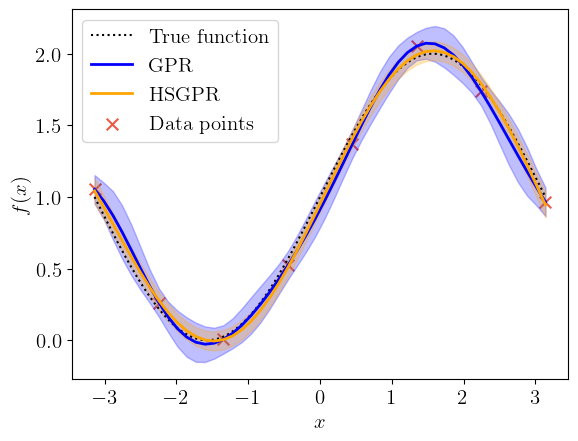

<Figure size 640x480 with 0 Axes>

In [6]:
#Models for regression
alpha = 1.0
scale = 1.

L = 6
M = 2**2 

## Exponential kernel regression to visualize the GPR of the function
GK = GP_regressors.Gaussian_kernel_GPR((X_eval, y_eval ),sigma2=sigma2, alpha=alpha, scale=scale)
HS = GP_regressors.HS_approx_GPR((X_eval, y_eval ),sigma2=sigma2,L=L, M=M, alpha=alpha, scale=scale)

mu_post_exp_k, Sigma_post_exp_k = GK.posterior(Xp)
mu_post_approx_HS_k, Sigma_post_approx_HS_k = HS.posterior(Xp)

## Plotting
plt.plot(X_real, y, label="True function", linestyle="dotted", color='k')
plot_with_uncertainty(Xp, mu_post_exp_k, Sigma_post_exp_k, color='blue', name = "GPR")
plot_with_uncertainty(Xp, mu_post_approx_HS_k, Sigma_post_approx_HS_k, color='orange', name = "HSGPR")

plt.scatter(X_eval, y_eval , marker='x', label="Data points", color='#e82f17',zorder=0, s = 70, alpha=0.8)

plt.xlabel("$x$")
plt.ylabel("$f(x)$")
plt.legend()

plt.show()

plt.savefig("GPR_exp_kernel.pdf", bbox_inches='tight')


In [7]:
## Class for the Quadrature using the classical method

GPQ = Bayessian_quadratures.Gaussian_process_quadrature((X_eval, y_eval),
                                                        sigma2=sigma2, 
                                                        alpha=alpha, 
                                                        scale=scale, 
                                                        domain= domain)
HSQ = Bayessian_quadratures.Sine_HSQ((X_eval, y_eval ),
                                                sigma2=sigma2, 
                                                M=M, 
                                                L=L, 
                                                alpha=alpha, 
                                                scale=scale,
                                                domain= domain)

mu_post_GPQ, Sigma_post_GPQ = GPQ.quadrature_posterior()
mu_post_HSQ, Sigma_post_HSQ = HSQ.quadrature_posterior()








## integrate
I = integrate.quad(lambda x: f(x), x_i, x_f)
print("Real integral: ", I[0])

print("Integral approximation: ", mu_post_GPQ)
print("Integral approximation error: ", np.sqrt(Sigma_post_GPQ))
print("Integral approximation HS: ", mu_post_HSQ)
print("Integral approximation error HS: ", np.sqrt(Sigma_post_HSQ))


X_mu [ 3.55705398e+00  3.19929939e-17 -8.80654255e-01  0.00000000e+00]
Real integral:  6.283185307179586
Integral approximation:  [6.25922879]
Integral approximation error:  [[0.12499974]]
Integral approximation HS:  [6.27012044]
Integral approximation error HS:  0.11407113966819019


In [11]:
## evaluate the problem for N in [2, 3,4,5,6,7,8,9,10,11,12,13,14,15,16]
Ns = np.arange(2, 17)

n_eig=16
shots = 1000000
N_sim = 1
Rs = [1,2,3,4]
del_params = np.array([0.01, 0.009, 0.008, 0.007, 0.006])

means_GPQ = np.zeros((N_sim, len(Ns)))
stds_GPQ = np.zeros((N_sim, len(Ns)))

means_HSQ = np.zeros((N_sim, len(Ns)))
stds_HSQ = np.zeros((N_sim, len(Ns)))
                    
means_q = np.zeros((N_sim, len(Ns), len(Rs), len(del_params)))
stds_q = np.zeros((N_sim, len(Ns), len(Rs), len(del_params)))


#Models for regression
alpha = 1.0
scale = 1.0

L = 6
M = 2**2 

## Problem definition
## interval definition
x_i = -np.pi
x_f = np.pi
## Number of evaluation points
np.random.seed(679)
domain = [x_i, x_f]

## implementation using quantum circuit

for i in range(N_sim):
    for N in Ns:


        X_eval = np.linspace(start=x_i, stop=x_f, num=N).reshape(-1, 1)
        y_eval = np.squeeze(f(X_eval))
        ## Noise addition, this is noise in the measurements
        noise_std = 0.05

        y_eval = y_eval+ np.random.normal(0.0, noise_std, size=y_eval.shape)

        sigma2 = noise_std**2
        
        GPQ = Bayessian_quadratures.Gaussian_process_quadrature((X_eval, y_eval),
                                                        sigma2=sigma2, 
                                                        alpha=alpha, 
                                                        scale=scale, 
                                                        domain= domain)
        HSQ = Bayessian_quadratures.Sine_HSQ((X_eval, y_eval ),
                                                sigma2=sigma2, 
                                                M=M, 
                                                L=L, 
                                                alpha=alpha, 
                                                scale=scale,
                                                domain= domain)
        
        mu_post_GPQ, Sigma_post_GPQ = GPQ.quadrature_posterior()
        mu_post_HSQ, Sigma_post_HSQ = HSQ.quadrature_posterior()

        means_GPQ[i, N-2] = mu_post_GPQ
        stds_GPQ[i, N-2] = np.sqrt(Sigma_post_GPQ)

        means_HSQ[i, N-2] = mu_post_HSQ
        stds_HSQ[i, N-2] = np.sqrt(Sigma_post_HSQ)

        Phif = HSQ.Phi_matrix(X_eval).T
        Lambda = HSQ.Lambda()


        Z = np.array(Phif.T @ np.sqrt(Lambda))

        ## Normalize the data
        norm_z = np.linalg.norm(Z)

        Z_norm = Z/norm_z

        ZZd = np.array(Z_norm.T @ Z_norm)

        ## sigular value decomposition ZZd
        U, S, V = np.linalg.svd(Z_norm)
        real_eigenvals, real_eigenvecs = scipy.linalg.eig(ZZd)
        real_eigenvals = np.sort(real_eigenvals)[::-1]


        '''
        The delta parameter is important for accurately estimating the eigenvalues. The performance of the algorithm
        is very sensitive to the choice of delta. The delta parameter should be 1>delta>lam_max, 
        for demonstrations purposes we choose delta = lam_max + 0.012
        '''
        deltas = np.real(real_eigenvals[0])+del_params

        for j in range(len(del_params)):
            delta = deltas[j]
            for R in Rs:
                mean_args_post = [X_eval, y_eval, sigma2, M, L, alpha, scale, domain, delta, n_eig, R, shots]
                mu_post_approx_HS_k_QPU, Sigma_post_approx_HS_k_QPU, qc_swap = QGP_quadratures.QGPQ_approximation_posterior(mean_args_post)
                means_q[i, N-2, R-1, j] = mu_post_approx_HS_k_QPU
                stds_q[i, N-2, R-1, j] = np.sqrt(Sigma_post_approx_HS_k_QPU)

                print("R: ", R)
                print("Integral approximation QHS: ", mu_post_approx_HS_k_QPU)
                print("Integral approximation error QHS: ", np.sqrt(Sigma_post_approx_HS_k_QPU))
                
        print("N: ", N)
        print("Integral approximation HS: ", mu_post_HSQ)
        print("Integral approximation error HS: ", np.sqrt(Sigma_post_HSQ))
        print("Delta: ", delta)
    print("Simulation: ", i)


means_GPQ = means_GPQ[0,:]
stds_GPQ = stds_GPQ[0,:]
means_HSQ = means_HSQ[0,:]
stds_HSQ = stds_HSQ[0,:]

X_mu [ 3.55705398e+00  3.19929939e-17 -8.80654255e-01  0.00000000e+00]
Real eigenvalues bef:  [ 5.04494313e-01+0.j  4.95505687e-01+0.j  0.00000000e+00+0.j
 -9.46332110e-19+0.j]
Real eigenvalues after:  [ 5.04494313e-01+0.j  4.95505687e-01+0.j  0.00000000e+00+0.j
 -9.46332110e-19+0.j]
Quantum eigenvalues:  [0.5044926994426837, 0.03141794191232175, 0.004671083317798961, 0.003540602649289633]
Quantum eigenvalues keys:  ['1111101100000110', '0000111110100010', '0000001001010011', '0000000111000011']
R:  1
Integral approximation QHS:  3.0063843634875416
Integral approximation error QHS:  0.11935997134385339
Real eigenvalues bef:  [ 5.04494313e-01+0.j  4.95505687e-01+0.j  0.00000000e+00+0.j
 -9.46332110e-19+0.j]
Real eigenvalues after:  [ 5.04494313e-01+0.j  4.95505687e-01+0.j  0.00000000e+00+0.j
 -9.46332110e-19+0.j]
Quantum eigenvalues:  [0.5044926994426837, 0.03141794191232175, 0.004671083317798961, 0.003540602649289633]
Quantum eigenvalues keys:  ['1111101100000110', '0000111110100010', 

In [104]:
## save data
np.save("Data/means_GPQ.npy", means_GPQ)
np.save("Data/stds_GPQ.npy", stds_GPQ)
np.save("Data/means_HSQ.npy", means_HSQ)
np.save("Data/stds_HSQ.npy", stds_HSQ)
np.save("Data/means_data.npy", means_q)
np.save("Data/stds_data.npy", stds_q)

In [105]:
## load files of data
means_GPQ = np.load("Data/means_GPQ.npy")
stds_GPQ = np.load("Data/stds_GPQ.npy")
means_HSQ = np.load("Data/means_HSQ.npy")
stds_HSQ = np.load("Data/stds_HSQ.npy")
means_q = np.load("Data/means_data.npy")
stds_q = np.load("Data/stds_data.npy")


In [106]:
##This function makes the plots easy  
def plot_with_uncertainty(Xp, mu, Sigma, color='r', title="", name = "Mean", linewidth=2.0, linestyle='-', marker = None):
    
    mean, std = mu.ravel(), np.sqrt(np.diag(Sigma))

    # plot distribution
    plt.plot(Xp, mean, color=color,  label=name, linewidth=linewidth, linestyle=linestyle, marker = marker)
    plt.fill_between(Xp.ravel(), mean - 2*std, mean + 2*std, color=color, alpha=0.25)
    
    plt.title(title)

def gaussian_pdf(x, mean, variance):
    std = np.sqrt(variance)
    return np.exp(-0.5*((x-mean)/std)**2)/(std*np.sqrt(2*np.pi))
## function to plot a gaussian with mean, variance and color filling
def plot_gaussian(mean, variance, color, label, intensity=1, linestyle='-', dashes=(5, 5)):
    std = np.sqrt(variance)
    ## plot a gaussian probability density function with mean and variance

    means = np.linspace(mean - 3*std, mean + 3*std, 100)
    pdf = gaussian_pdf(means, mean, variance)
    plt.plot(means, pdf, color, label=label, alpha=intensity, linestyle=linestyle)
    plt.fill_between(means, pdf, color=color, alpha=0.2*intensity)
    ## plot vertical line at the mean until the pdf
    plt.vlines(x = mean, ymax = max(pdf), ymin=0, color=color, alpha=intensity, linestyle= linestyle)            
    plt.legend()

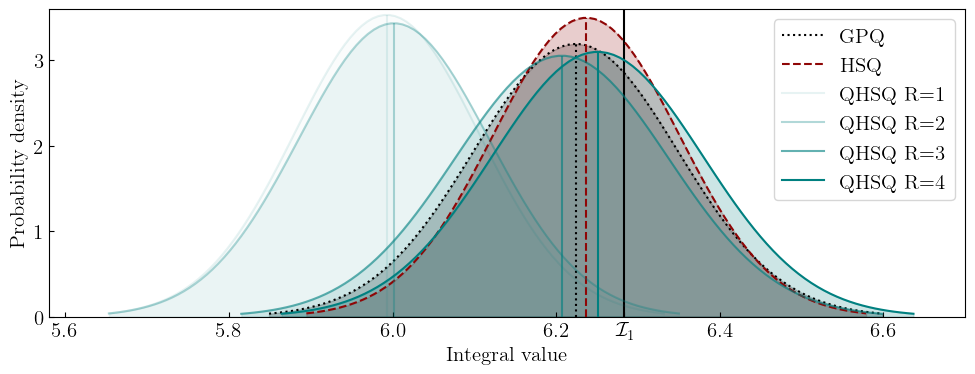

In [108]:
## Gaussian distributions plot
color_HSQ = "#8f0606"
color_QHSQ = "#008080"
color_GPQ = "k"
## Plotting
fig = plt.figure(figsize=(10, 4))
## vertical line at the real integral
plt.axvline(x=I[0],  color='k', linestyle='-', linewidth=1.5)


## Gaussian PQ
plot_gaussian(means_GPQ[6], stds_GPQ[6]**2, color=color_GPQ, label="GPQ", intensity=1, linestyle=':')
## Gaussian HSQ
plot_gaussian(means_HSQ[6], stds_HSQ[6]**2, color=color_HSQ, label="HSQ", intensity=1, linestyle='--')

## quantum approximations
plt.ylim(0, 3.6)
plt.xlabel("Integral value")
plt.ylabel("Probability density")
for R in [1,2,3,4]:
    plot_gaussian(means_q[6, R-1, 0], stds_q[6, R-1, 0]**2, color=color_QHSQ, label="QHSQ R={}".format(R), intensity=(R/4)**1.7, linestyle='-')

plt.tick_params(direction='in')
plt.xticks([ 5.6, 5.8, 6.0, 6.2, 6.4, 6.6, 6.8])
plt.xticks(list(plt.xticks()[0]) + [I[0]], list(plt.xticks()[0]) + [r'$\mathcal{I}_1$'])
plt.legend(loc="upper right")

plt.xlim(5.58, 6.7)

## add xtick with the real integral value and label 

plt.tight_layout()
plt.savefig("Figures/integral_gaussian_distribution.pdf")
plt.show()  


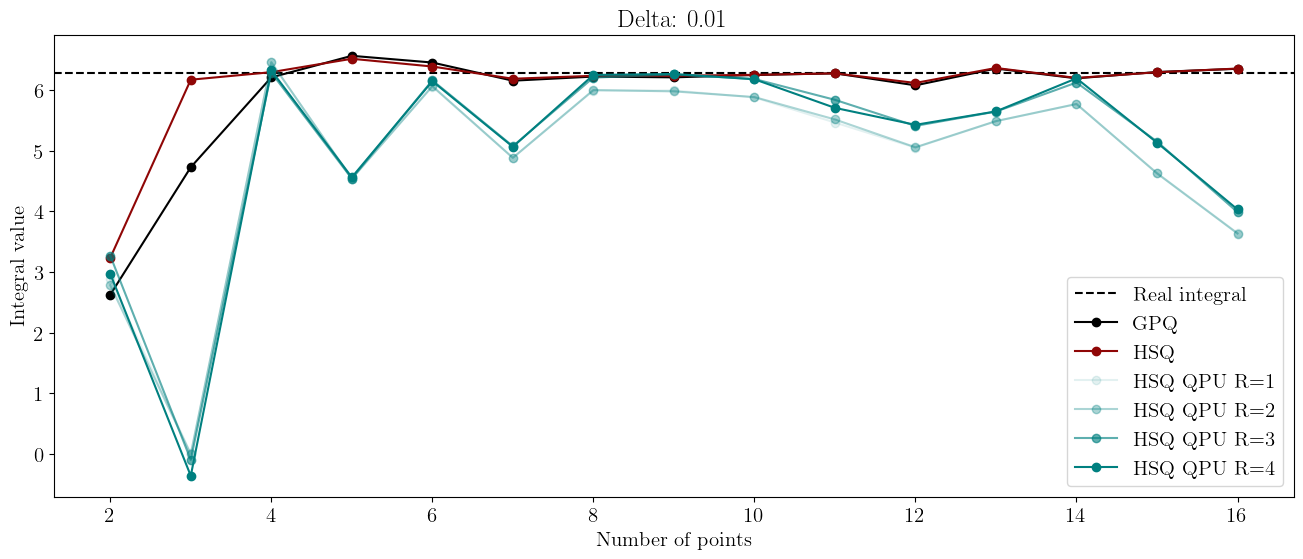

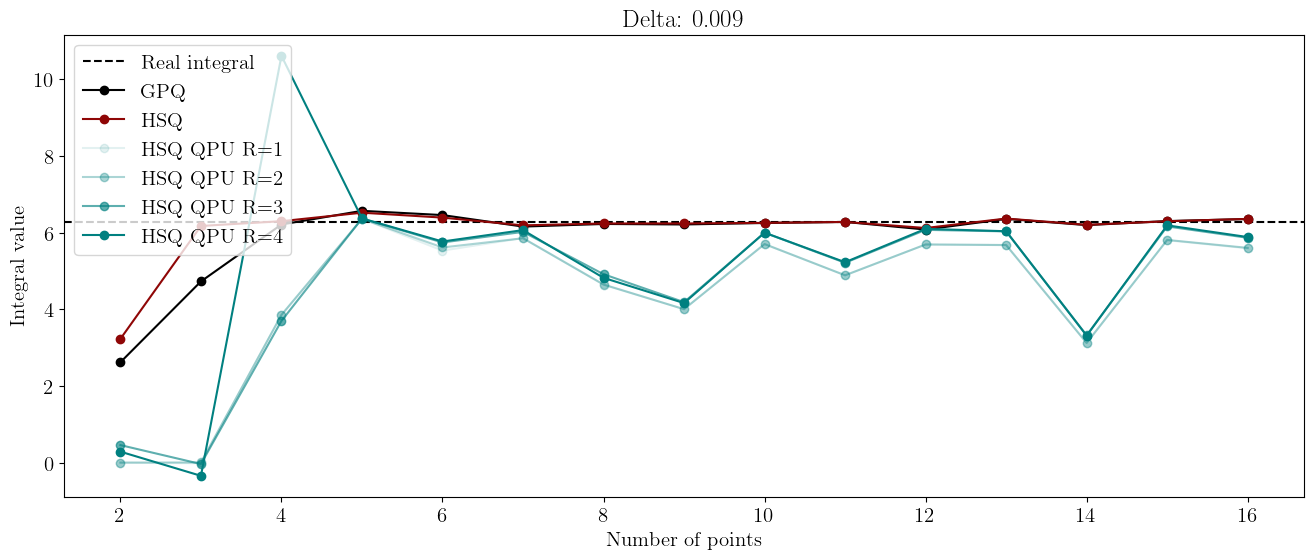

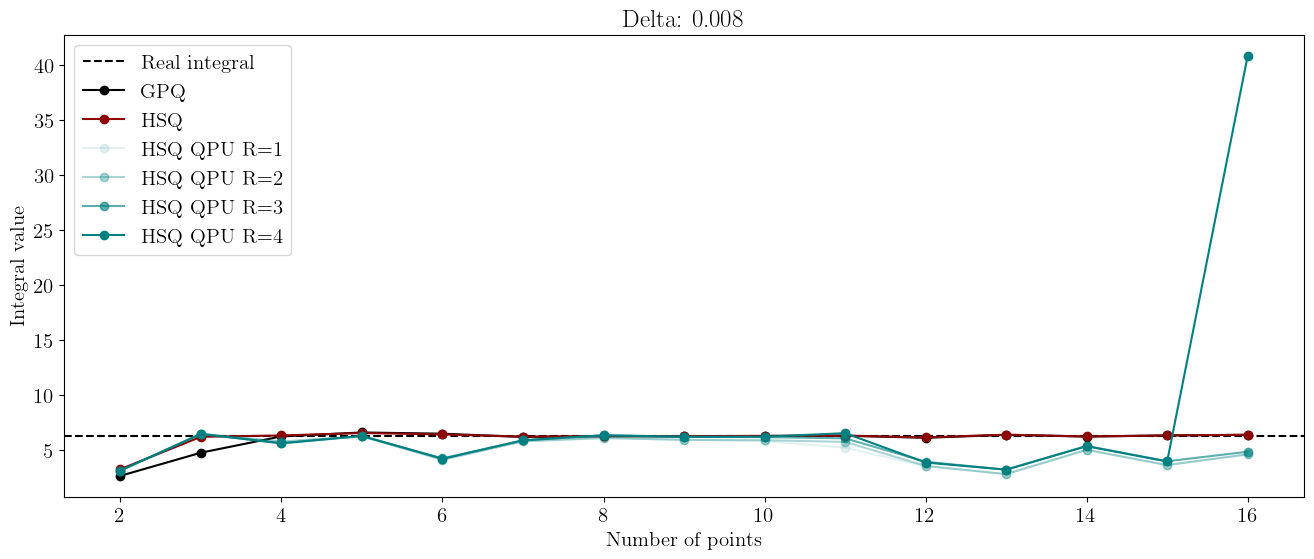

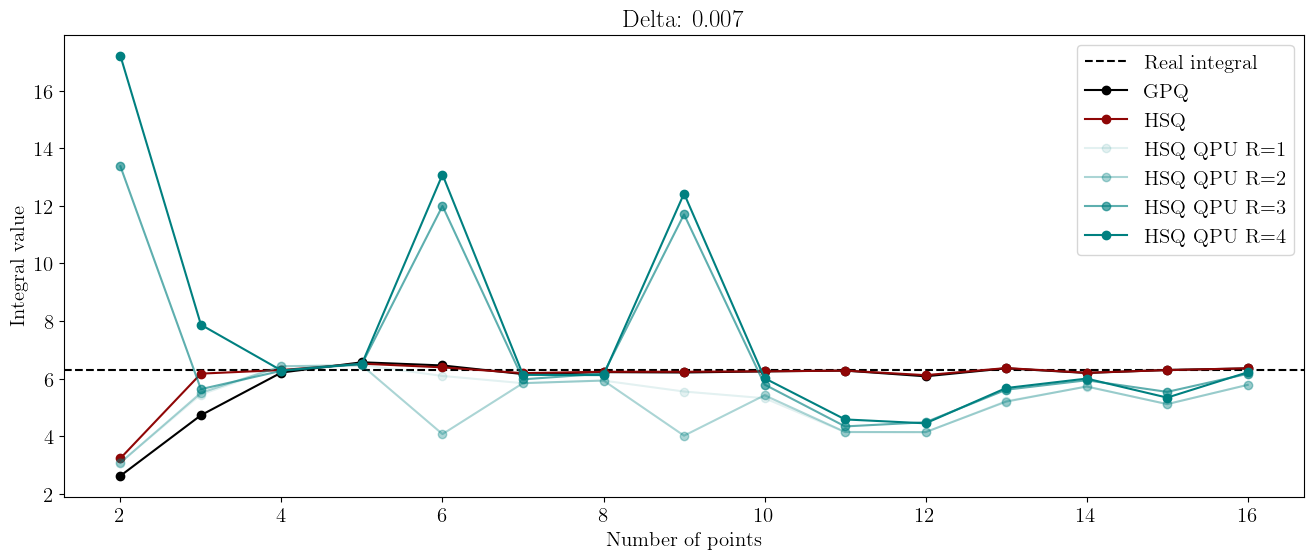

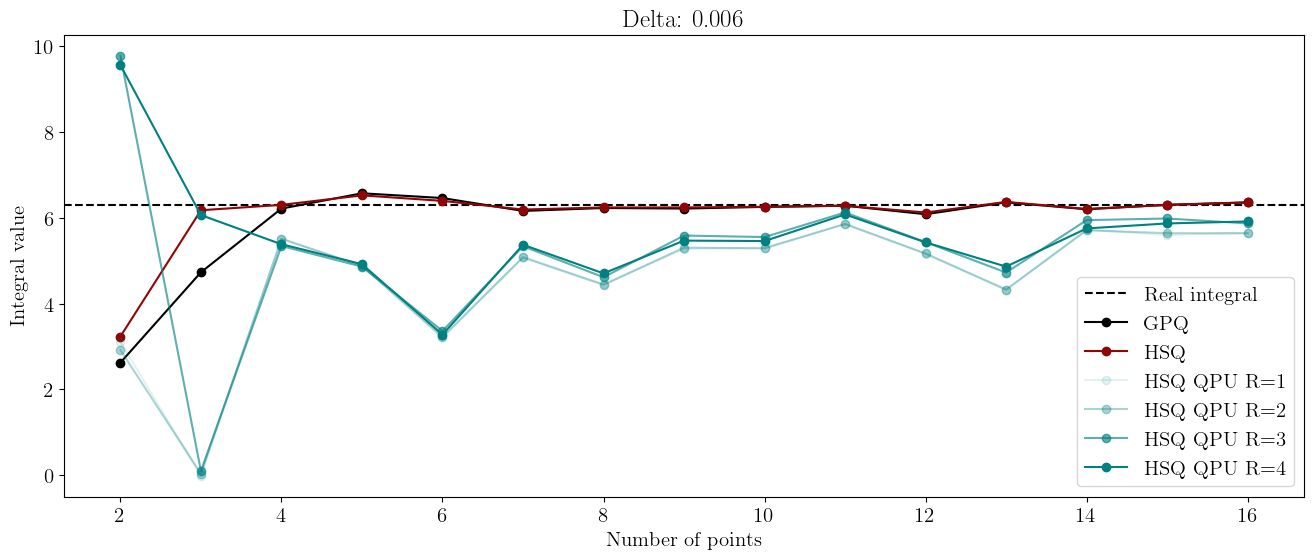

In [109]:

## Plotting for every delta
for j in range(len(del_params)):
    fig = plt.figure(figsize=(16, 6))
## horixontal line at the real integral
    plt.axhline(y=I[0], color='k', linestyle='--', label="Real integral")

    plt.ylabel("Integral value")
    plt.xlabel("Number of points")
    plt.plot(Ns, means_GPQ, color=color_GPQ, label="GPQ", linestyle='-', marker='o') 
    plt.plot(Ns, means_HSQ, color= color_HSQ, label="HSQ", linestyle='-', marker='o')
    for R in Rs:
        plt.plot(Ns, means_q[:, R-1, j], color=color_QHSQ, label="HSQ QPU R={}".format(R), linestyle='-', marker='o', alpha=(R/4)**1.6)
    plt.title("Delta: {}".format(del_params[j]))
    plt.legend()
    plt.show()

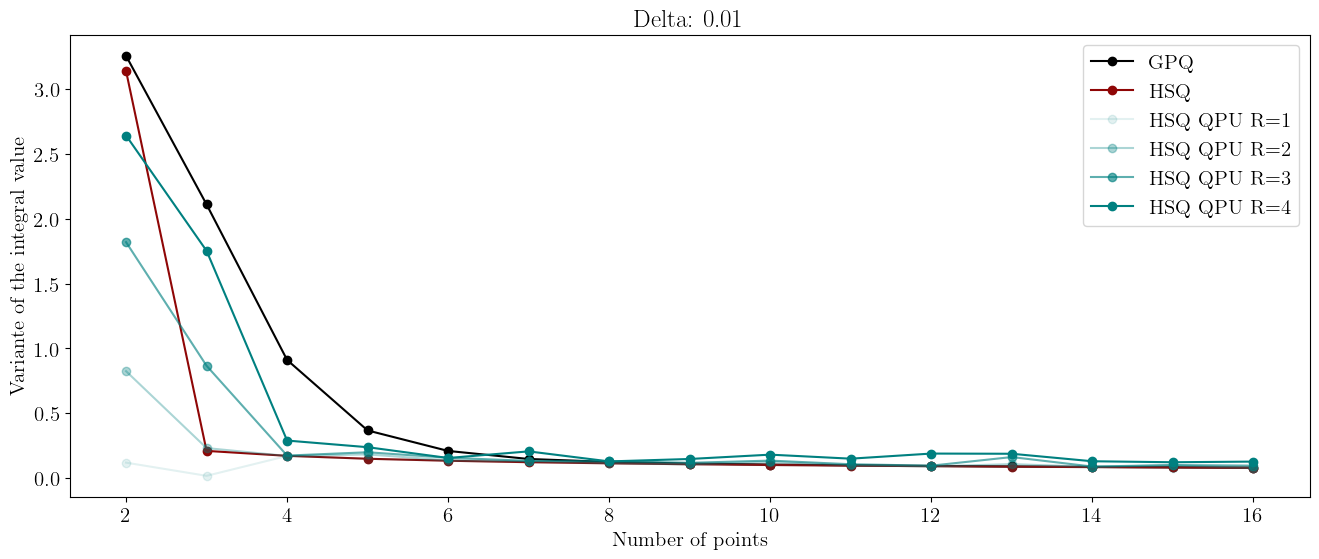

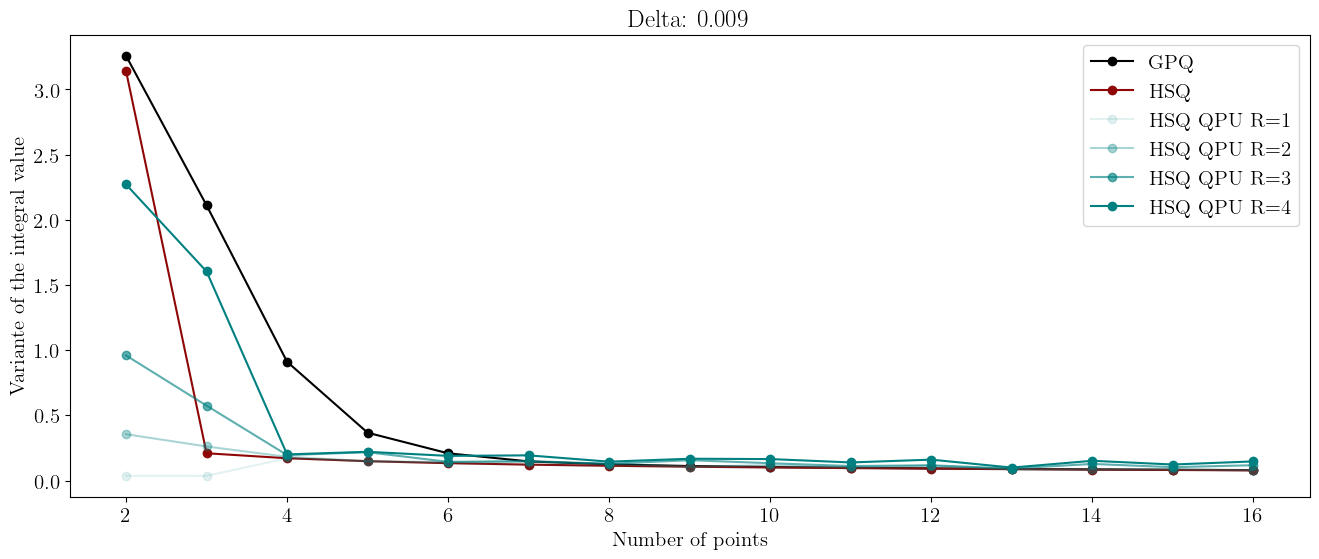

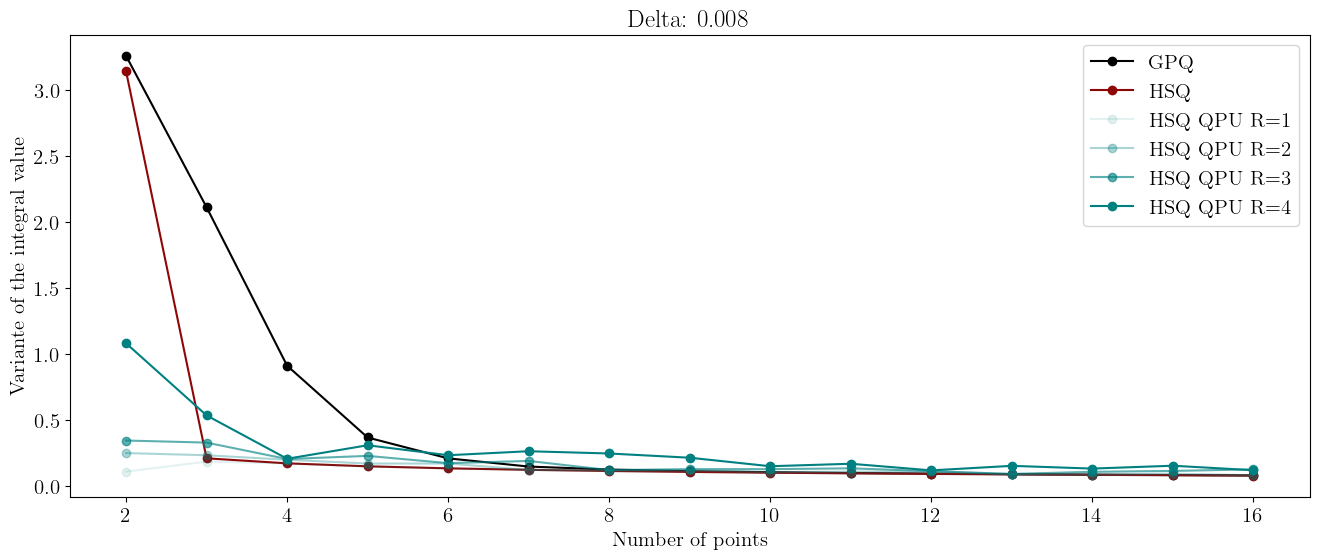

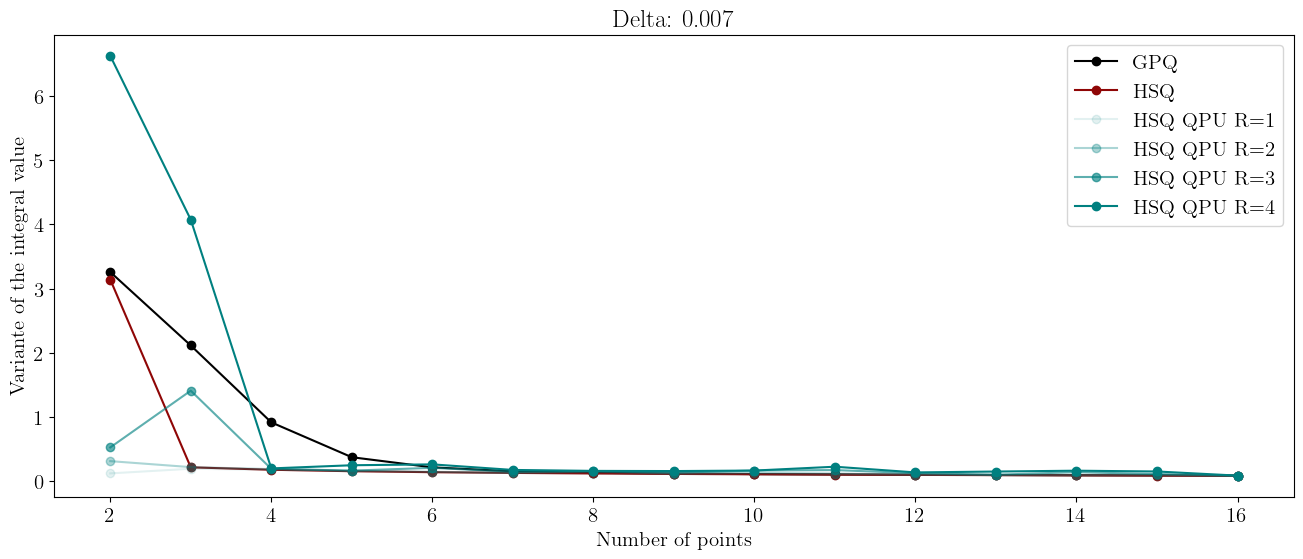

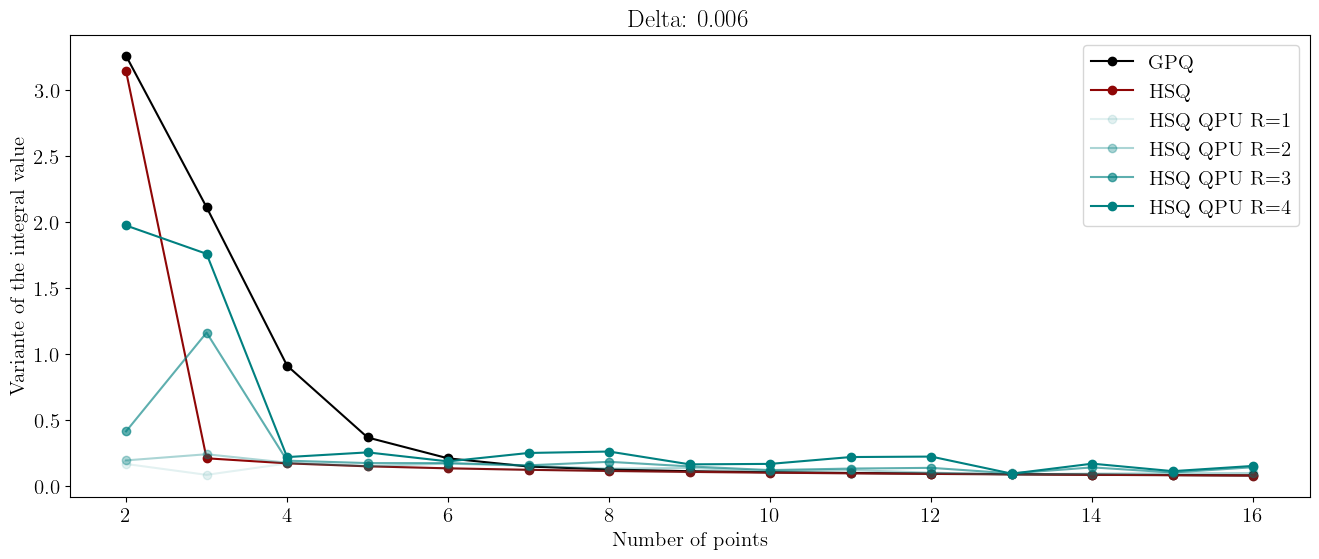

In [110]:
## Plotting for every delta variance
for j in range(len(del_params)):
    fig = plt.figure(figsize=(16, 6))

    plt.ylabel("Variante of the integral value")
    plt.xlabel("Number of points")
    plt.plot(Ns, stds_GPQ, color=color_GPQ, label="GPQ", linestyle='-', marker='o')
    plt.plot(Ns, stds_HSQ, color=color_HSQ, label="HSQ", linestyle='-', marker='o')
    for R in Rs:
        plt.plot(Ns, stds_q[:, R-1, j],  color=color_QHSQ, label="HSQ QPU R={}".format(R), linestyle='-', marker='o', alpha=(R/4)**1.6)
    plt.title("Delta: {}".format(del_params[j]))
    plt.legend()
    plt.show()

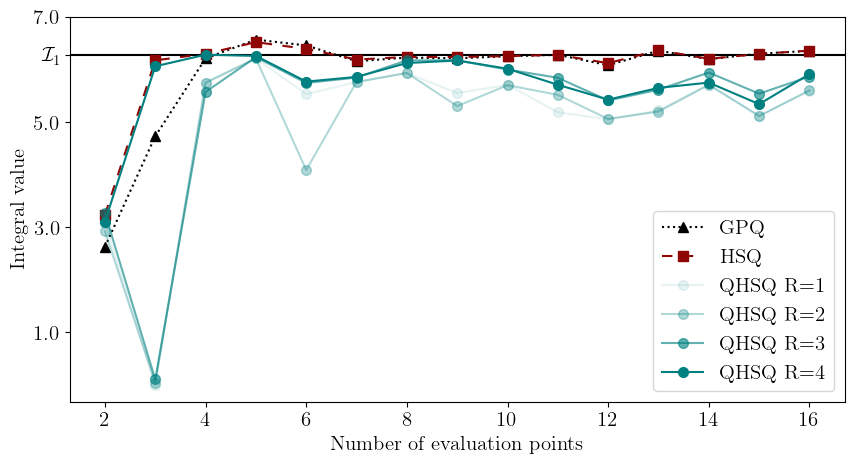

In [111]:
## take the median over the delta parameters
means_q_media = np.median(means_q, axis=2)

## Plotting for every R
fig = plt.figure(figsize=(10, 5))

## horizontal line at the real integral
plt.axhline(y=I[0], color='k', linestyle='-', linewidth=1.5)


plt.ylabel("Integral value")
plt.xlabel("Number of evaluation points")
## plot the mean against the number of evaluation points
plt.plot(Ns, means_GPQ, color = color_GPQ,label="GPQ", linestyle=':', marker='^', markersize=7)
plt.plot(Ns, means_HSQ, color = color_HSQ,label="HSQ", linestyle='--', marker='s', markersize=7, dashes=(5, 5))
for R in Rs:
    plt.plot(Ns, means_q_media[:, R-1],  color=color_QHSQ, label="QHSQ R={}".format(R), linestyle='-', marker='o', markersize=7, alpha=(R/4)**1.7)

#plt.ylim(2.6, 7)
## yticks  = [0.0, 1.0 3.0, 5.0, 7.0]
plt.yticks([ 1.0 ,3.0, 5.0, 7.0])
plt.yticks(list(plt.yticks()[0]) + [I[0]], list(plt.yticks()[0]) + [r'$\mathcal{I}_1$'])

plt.legend()
plt.savefig("Figures/integral_mean.pdf")

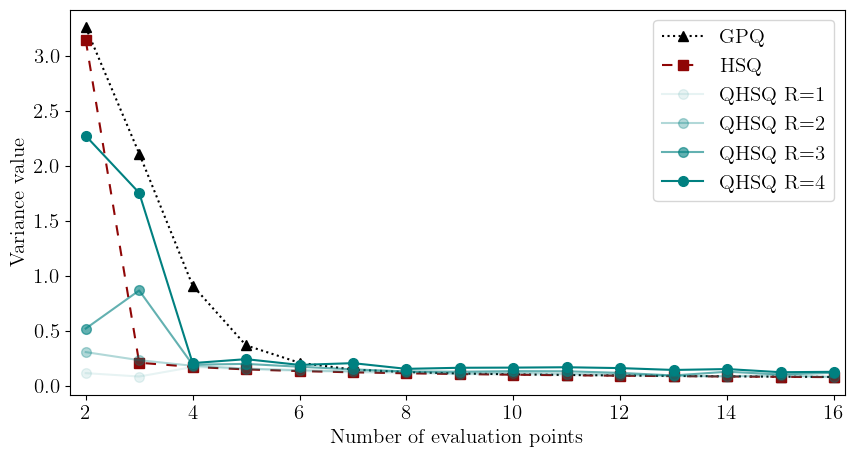

In [112]:
## take the median over the delta parameters
stds_q_media = np.median(stds_q, axis=2)

## Plotting for every R
fig = plt.figure(figsize=(10, 5))


plt.ylabel("Variance value")
plt.xlabel("Number of evaluation points")

plt.plot(Ns, stds_GPQ_m, color=color_GPQ, label="GPQ", linestyle=':', marker='^', markersize=7)
plt.plot(Ns, stds_HSQ_m, color=color_HSQ, label="HSQ", linestyle='--', marker='s', markersize=7, dashes=(5, 5))

for R in Rs:
    plt.plot(Ns, stds_q_media[:, R-1],  color=color_QHSQ, label="QHSQ R={}".format(R), linestyle='-', marker='o', markersize=7, alpha=(R/4)**1.7)

plt.legend()
plt.xlim(1.7, 16.2)
plt.savefig("Figures/integral_variance.pdf")


<function matplotlib.pyplot.show(close=None, block=None)>

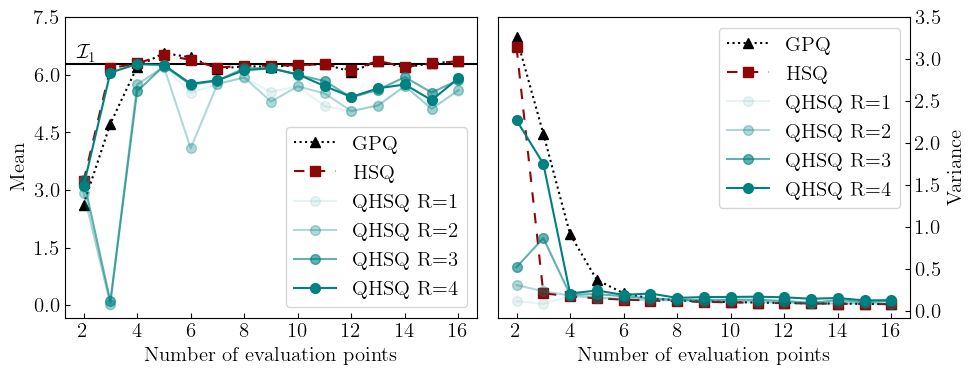

In [113]:
## plot mean and variance beside each other for the paper
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

## horizontal line at the real integral
ax[0].axhline(y=I[0], color='k', linestyle='-', linewidth=1.5)
## plot the mean against the number of evaluation points
ax[0].plot(Ns, means_GPQ, color = color_GPQ,label="GPQ", linestyle=':', marker='^', markersize=7)
ax[0].plot(Ns, means_HSQ, color = color_HSQ,label="HSQ", linestyle='--', marker='s', markersize=7, dashes=(5, 5))
for R in Rs:
    ax[0].plot(Ns, means_q_media[:, R-1],  color=color_QHSQ , label="QHSQ R={}".format(R), linestyle='-', marker='o', markersize=7, alpha=(R/4)**1.7)

ax[0].tick_params(direction='in')
ax[0].set_ylabel("Mean")
ax[0].set_xlabel("Number of evaluation points")
ax[0].set_yticks([ 0 ,1.5, 3.0, 4.5, 6.0, 7.5])
ax[0].set_xticks([ 2 ,4, 6, 8, 10, 12, 14, 16])
ax[0].legend()

plt.text(0.05, 0.88, '$\mathcal{I}_1$', horizontalalignment='center', verticalalignment='center', rotation=0, transform=ax[0].transAxes)

## plot the variance against the number of evaluation points
ax[1].tick_params(direction='in')
ax[1].plot(Ns, stds_GPQ, color = color_GPQ,label="GPQ", linestyle=':', marker='^', markersize=7)
ax[1].plot(Ns, stds_HSQ, color = color_HSQ,label="HSQ", linestyle='--', marker='s', markersize=7, dashes=(5, 5))
for R in Rs:
    ax[1].plot(Ns, stds_q_media[:, R-1],  color=color_QHSQ, label="QHSQ R={}".format(R), linestyle='-', marker='o', markersize=7, alpha=(R/4)**1.7)

ax[1].set_ylabel("Variance")
ax[1].set_xticks([ 2 ,4, 6, 8, 10, 12, 14, 16])
ax[1].set_yticks([ 0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5])
ax[1].set_xlabel("Number of evaluation points")

ax[1].legend()

## Move ticks to the right in second plot
ax[1].yaxis.tick_right()
ax[1].yaxis.set_label_position("right")
## tight layout
fig.tight_layout()
## join the two plots, no space in between
plt.subplots_adjust(wspace=0.05)
plt.savefig("Figures/integral_mean_variance.pdf")
plt.show